<a href="https://colab.research.google.com/github/yanov2708/SMR/blob/main/lab2_statistical_methods_of_object_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Task

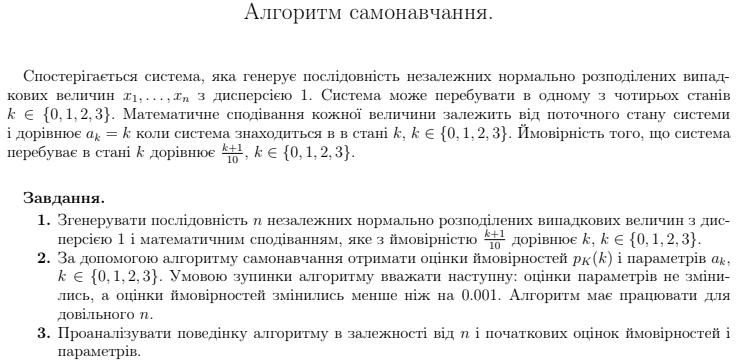

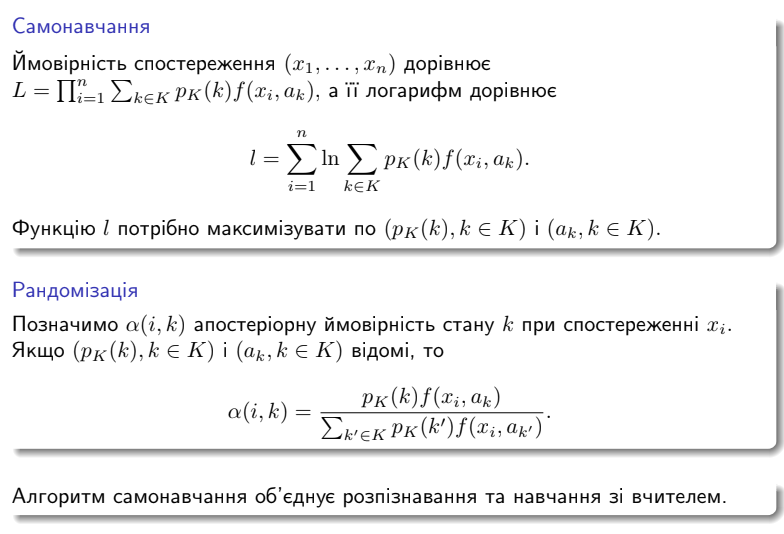

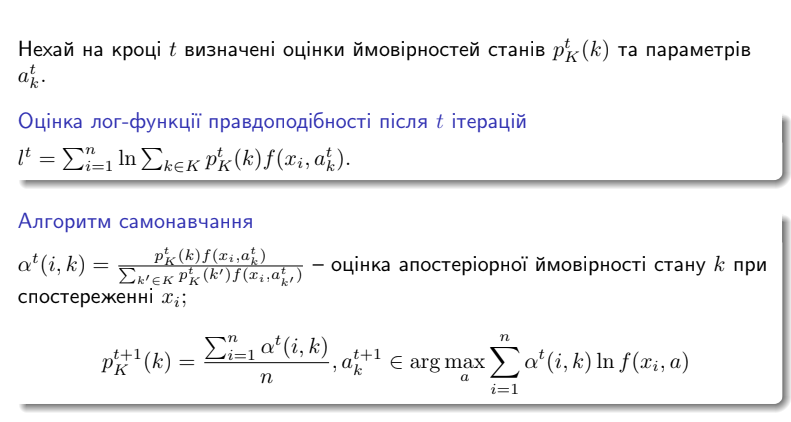

## 1) Генерація

In [ ]:
def generate_sequence(n):
    """
    Генерує послідовність незалежних нормально розподілених величин
    з дисперсією 1 та математичними сподіваннями, залежними від стану системи.

    Parameters:
    n (int): Кількість величин у послідовності.

    Returns:
    sequence (list): Згенерована послідовність.
    states (list): Відповідні стани системи.
    """
    # Початкові параметри
    states = [0, 1, 2, 3]                                       # Можливі стани
    transition_probabilities = [(k + 1) / 10 for k in states]   # Ймовірності переходу
    a_k = [k for k in states]                                   # Математичні сподівання для кожного стану

    # Ініціалізація
    current_state = np.random.choice(states)  # Початковий стан
    sequence = []
    state_sequence = []

    for _ in range(n):
        # Генеруємо випадкову величину для поточного стану
        mean = a_k[current_state]
        value = np.random.normal(loc=mean, scale=1)
        sequence.append(value)
        state_sequence.append(current_state)

        # Переходимо до нового стану
        current_state = np.random.choice(states, p=transition_probabilities)

    return sequence, state_sequence



n = 100
sequence, state_sequence = generate_sequence(n)
print("Перші 10 значень послідовності:", sequence[:10])
print("Відповідні стани:", state_sequence[:10])

Перші 10 значень послідовності: [0.3567997276872654, 2.3604045076379103, 3.469969484163252, 4.696916327610494, 2.7198608526583845, 1.7552898029924404, 2.011516715286202, 2.75055375556378, 4.363935131611145, 4.014848018170035]
Відповідні стани: [2, 2, 3, 3, 2, 1, 3, 3, 3, 3]


## 2) ЕМ

In [ ]:
def initialize_parameters(states):
    """
    Ініціалізує параметри алгоритму самонавчання.

    Parameters:
    states (list): Список можливих станів системи.

    Returns:
    p_k (dict): Початкові ймовірності станів.
    a_k (dict): Початкові значення параметрів a_k для кожного стану.
    """
    p_k = {k: 1 / len(states) for k in states}  # Рівні ймовірності
    a_k = {k: np.random.uniform(0, 1) for k in states}  # Випадкові a_k
    return p_k, a_k

def compute_alpha(xi, states, p_k, a_k):
    """
    Обчислює апостеріорні ймовірності α(i, k).

    Parameters:
    xi (float): Спостереження.
    states (list): Список можливих станів.
    p_k (dict): Ймовірності станів.
    a_k (dict): Значення параметрів a_k.

    Returns:
    alpha (dict): Апостеріорні ймовірності для всіх станів.
    """
    alpha = {}
    denominator = sum(p_k[k] * normal_pdf(xi, a_k[k], 1) for k in states)  # Знаменник формули
    for k in states:
        numerator = p_k[k] * normal_pdf(xi, a_k[k], 1)  # Чисельник
        alpha[k] = numerator / denominator
    return alpha

def normal_pdf(x, mean, variance):
    """
    Обчислює щільність нормального розподілу.

    Parameters:
    x (float): Значення.
    mean (float): Середнє значення.
    variance (float): Дисперсія.

    Returns:
    float: Значення щільності.
    """
    return (1 / np.sqrt(2 * np.pi * variance)) * np.exp(-((x - mean) ** 2) / (2 * variance))

def update_parameters(data, states, alpha):
    """
    Оновлює параметри p_K(k) та a_k.

    Parameters:
    data (list): Набір спостережень.
    states (list): Список можливих станів.
    alpha (list): Апостеріорні ймовірності.

    Returns:
    p_k (dict): Оновлені ймовірності станів.
    a_k (dict): Оновлені значення параметрів a_k.
    """
    n = len(data)
    p_k = {k: sum(alpha[i][k] for i in range(n)) / n for k in states}
    a_k = {
        k: sum(alpha[i][k] * data[i] for i in range(n)) / sum(alpha[i][k] for i in range(n))
        for k in states
    }
    return p_k, a_k

def compute_log_likelihood(data, states, p_k, a_k):
    """
    Обчислює лог-функцію правдоподібності.

    Parameters:
    data (list): Набір спостережень.
    states (list): Список можливих станів.
    p_k (dict): Ймовірності станів.
    a_k (dict): Значення параметрів a_k.

    Returns:
    float: Значення лог-функції.
    """
    log_likelihood = 0
    for xi in data:
        likelihood = sum(p_k[k] * normal_pdf(xi, a_k[k], 1) for k in states)
        log_likelihood += np.log(likelihood)
    return log_likelihood

def self_learning_algorithm(data, states, max_iterations=100, tolerance=0.001):
    """
    Реалізація алгоритму самонавчання.

    Parameters:
    data (list): Набір спостережень.
    states (list): Список можливих станів.
    max_iterations (int): Максимальна кількість ітерацій.
    tolerance (float): Точність зупинки.

    Returns:
    p_k (dict): Остаточні ймовірності станів.
    a_k (dict): Остаточні значення параметрів a_k.
    log_likelihood_history (list): Історія лог-функції правдоподібності.
    """
    # Ініціалізація параметрів
    p_k, a_k = initialize_parameters(states)
    log_likelihood_history = []

    for iteration in range(max_iterations):
        # Обчислення апостеріорних ймовірностей
        alpha = [compute_alpha(xi, states, p_k, a_k) for xi in data]

        # Оновлення параметрів
        p_k, a_k = update_parameters(data, states, alpha)

        # Обчислення лог-функції правдоподібності
        log_likelihood = compute_log_likelihood(data, states, p_k, a_k)
        log_likelihood_history.append(log_likelihood)

        print(f"Ітерація {iteration + 1}: лог-правдоподібність = {log_likelihood}")

        # Перевірка умови зупинки
        if len(log_likelihood_history) > 1 and abs(log_likelihood_history[-1] - log_likelihood_history[-2]) < tolerance:
            break

    return p_k, a_k, log_likelihood_history

In [ ]:
def plot_log_likelihood(log_likelihood_history):
    """
    Візуалізація зміни лог-функції правдоподібності.

    Parameters:
    log_likelihood_history (list): Історія значень лог-функції правдоподібності.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(log_likelihood_history) + 1), log_likelihood_history, marker='o')
    plt.title("Зміна лог-функції правдоподібності під час навчання")
    plt.xlabel("Номер ітерації")
    plt.ylabel("Лог-функція правдоподібності")
    plt.grid(True)
    plt.show()

def plot_distributions(data, states, p_k, a_k):
    """
    Візуалізація оцінених розподілів і даних.

    Parameters:
    data (list): Набір спостережень.
    states (list): Список можливих станів.
    p_k (dict): Остаточні ймовірності станів.
    a_k (dict): Остаточні значення параметрів a_k.
    """
    plt.figure(figsize=(10, 6))

    # Гістограма даних
    count, bins, _ = plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Дані')

    # Відображення кожного стану
    x = np.linspace(min(data) - 1, max(data) + 1, 200)
    total_pdf = np.zeros_like(x)
    for k in states:
        pdf = p_k[k] * normal_pdf(x, a_k[k], 1)
        total_pdf += pdf
        plt.plot(x, pdf, linestyle='--', label=f"Стан {k}, p={p_k[k]:.2f}, a={a_k[k]:.2f}")

    # Сумарний розподіл
    plt.plot(x, total_pdf, 'r-', linewidth=2, label='Суміш розподілів')

    plt.title("Оцінені нормальні розподіли")
    plt.xlabel("Значення")
    plt.ylabel("Щільність ймовірності")
    plt.legend()
    plt.grid(True)
    plt.show()

Ітерація 1: лог-правдоподібність = -170.84688120783736
Ітерація 2: лог-правдоподібність = -168.6332635600553
Ітерація 3: лог-правдоподібність = -166.85467785794134
Ітерація 4: лог-правдоподібність = -166.05100963208415
Ітерація 5: лог-правдоподібність = -165.80662981670426
Ітерація 6: лог-правдоподібність = -165.73267164022255
Ітерація 7: лог-правдоподібність = -165.69950673908417
Ітерація 8: лог-правдоподібність = -165.67776132849696
Ітерація 9: лог-правдоподібність = -165.66091690929545
Ітерація 10: лог-правдоподібність = -165.64696496186127
Ітерація 11: лог-правдоподібність = -165.63494248002465
Ітерація 12: лог-правдоподібність = -165.62426329645305
Ітерація 13: лог-правдоподібність = -165.61454331023248
Ітерація 14: лог-правдоподібність = -165.60552648261907
Ітерація 15: лог-правдоподібність = -165.59704183182032
Ітерація 16: лог-правдоподібність = -165.58897551998362
Ітерація 17: лог-правдоподібність = -165.5812521956581
Ітерація 18: лог-правдоподібність = -165.5738224219707
Ітер

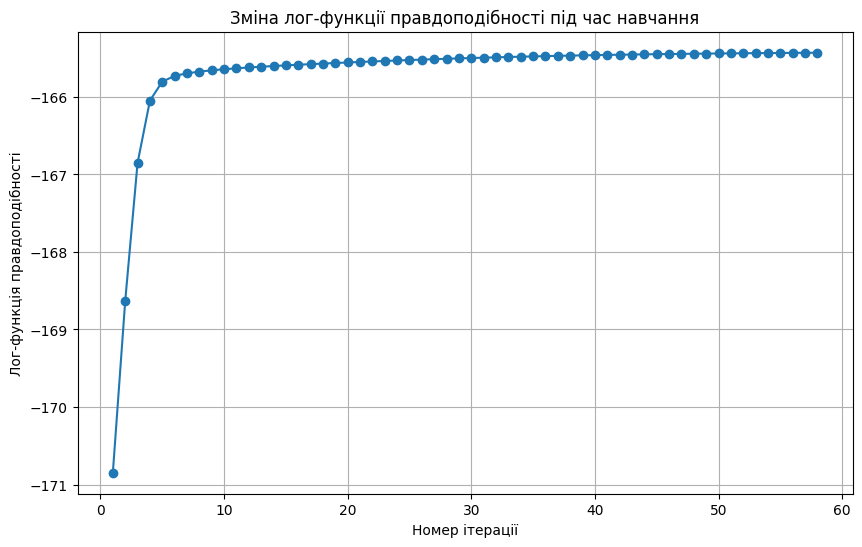

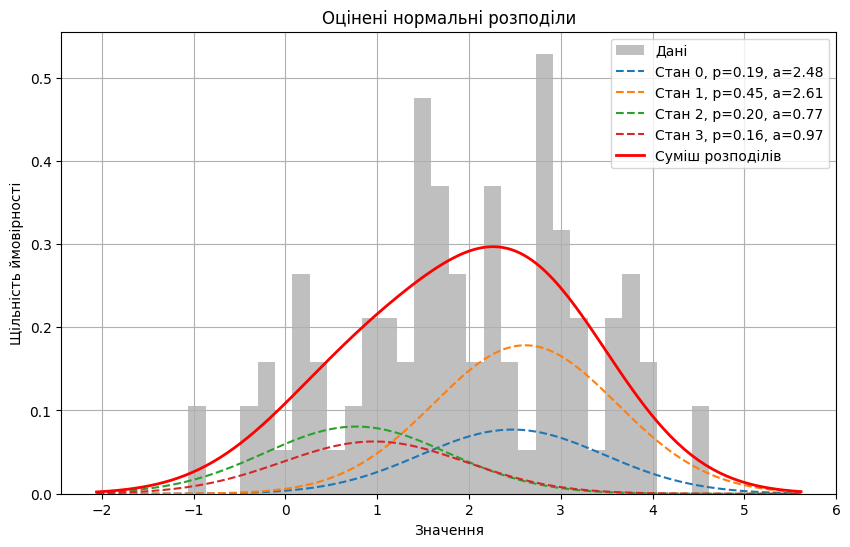

In [ ]:
if __name__ == "__main__":
    n = 100
    states = [0, 1, 2, 3]
    # np.random.seed(42)
    data, _ = generate_sequence(n)  # Генерація даних

    p_k, a_k, log_likelihood_history = self_learning_algorithm(data, states)

    print("Остаточні ймовірності станів:", p_k)
    print("Остаточні параметри a_k:", a_k)

    # Візуалізація
    plot_log_likelihood(log_likelihood_history)
    plot_distributions(data, states, p_k, a_k)

Ітерація 1: лог-правдоподібність = -1835.644229083861
Ітерація 2: лог-правдоподібність = -1785.8145407580494
Ітерація 3: лог-правдоподібність = -1769.0544405394976
Ітерація 4: лог-правдоподібність = -1765.9899838882743
Ітерація 5: лог-правдоподібність = -1765.2178668637237
Ітерація 6: лог-правдоподібність = -1764.8483465809031
Ітерація 7: лог-правдоподібність = -1764.6316598369385
Ітерація 8: лог-правдоподібність = -1764.501864604295
Ітерація 9: лог-правдоподібність = -1764.4242569121827
Ітерація 10: лог-правдоподібність = -1764.3776450130695
Ітерація 11: лог-правдоподібність = -1764.3491586151413
Ітерація 12: лог-правдоподібність = -1764.3311474041948
Ітерація 13: лог-правдоподібність = -1764.3191463492062
Ітерація 14: лог-правдоподібність = -1764.3105853455907
Ітерація 15: лог-правдоподібність = -1764.3040001097925
Ітерація 16: лог-правдоподібність = -1764.2985625291865
Ітерація 17: лог-правдоподібність = -1764.293806570986
Ітерація 18: лог-правдоподібність = -1764.2894706040518
Ітер

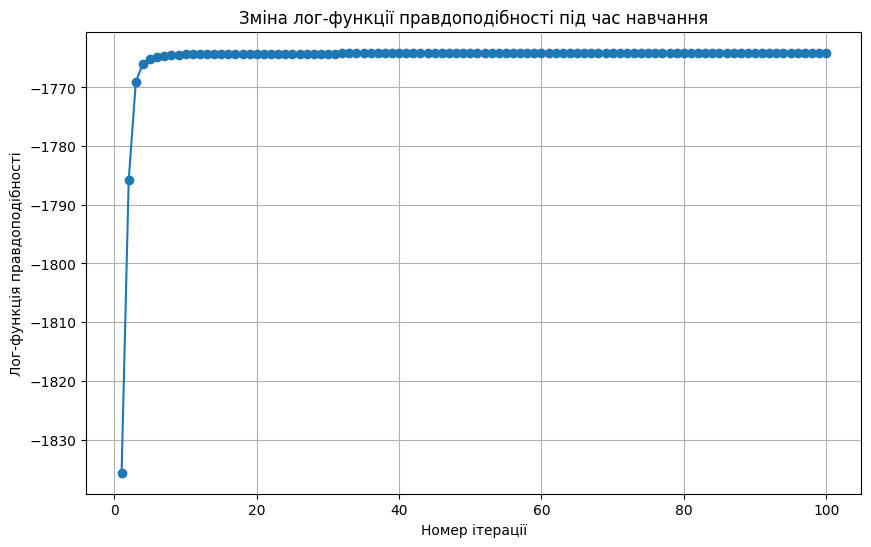

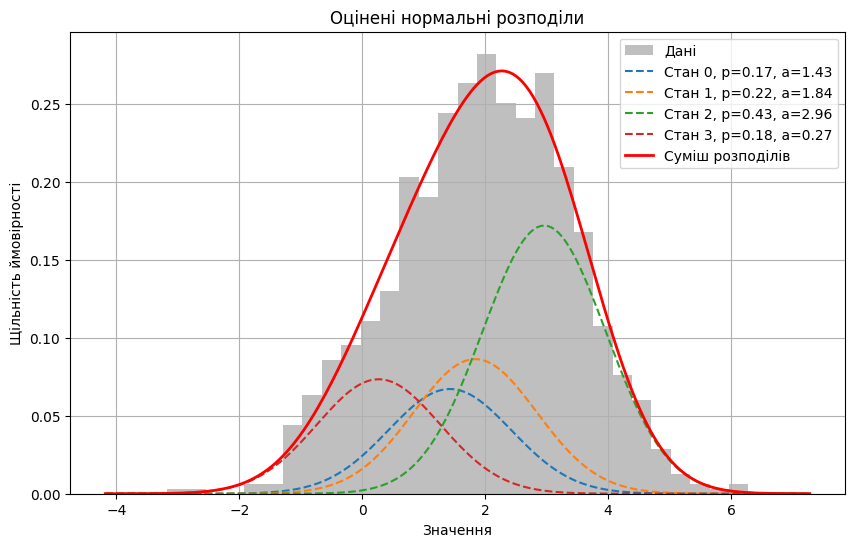

In [ ]:
if __name__ == "__main__":
    n = 1000
    states = [0, 1, 2, 3]
    # np.random.seed(42)
    data, _ = generate_sequence(n)  # Генерація даних

    p_k, a_k, log_likelihood_history = self_learning_algorithm(data, states)

    print("Остаточні ймовірності станів:", p_k)
    print("Остаточні параметри a_k:", a_k)

    # Візуалізація
    plot_log_likelihood(log_likelihood_history)
    plot_distributions(data, states, p_k, a_k)

Ітерація 1: лог-правдоподібність = -18216.950402759183
Ітерація 2: лог-правдоподібність = -17738.930093383322
Ітерація 3: лог-правдоподібність = -17637.498791440987
Ітерація 4: лог-правдоподібність = -17623.455080576347
Ітерація 5: лог-правдоподібність = -17619.212787927197
Ітерація 6: лог-правдоподібність = -17617.01932026264
Ітерація 7: лог-правдоподібність = -17615.754408857098
Ітерація 8: лог-правдоподібність = -17614.99317639326
Ітерація 9: лог-правдоподібність = -17614.510824184625
Ітерація 10: лог-правдоподібність = -17614.18377879532
Ітерація 11: лог-правдоподібність = -17613.944314093536
Ітерація 12: лог-правдоподібність = -17613.755524051052
Ітерація 13: лог-правдоподібність = -17613.597362303768
Ітерація 14: лог-правдоподібність = -17613.458927268213
Ітерація 15: лог-правдоподібність = -17613.334242016877
Ітерація 16: лог-правдоподібність = -17613.219966683868
Ітерація 17: лог-правдоподібність = -17613.114168315296
Ітерація 18: лог-правдоподібність = -17613.015664045095
Ітер

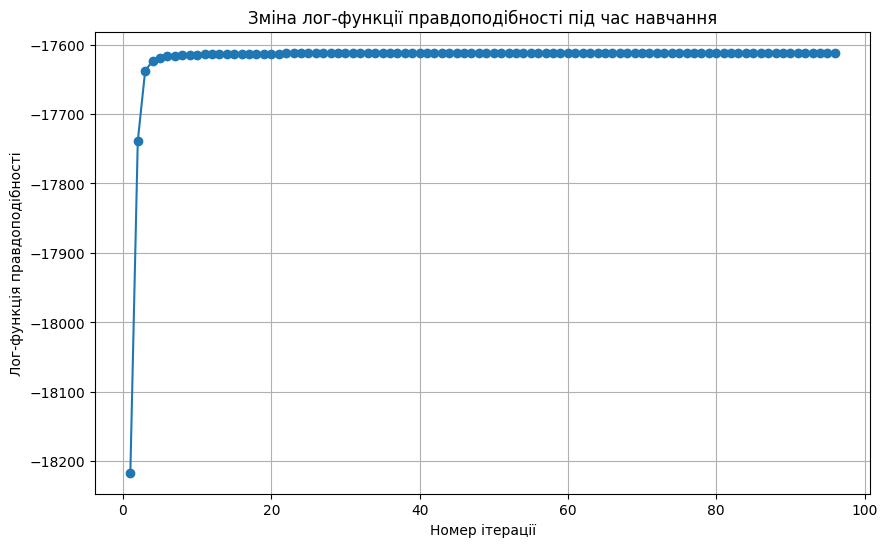

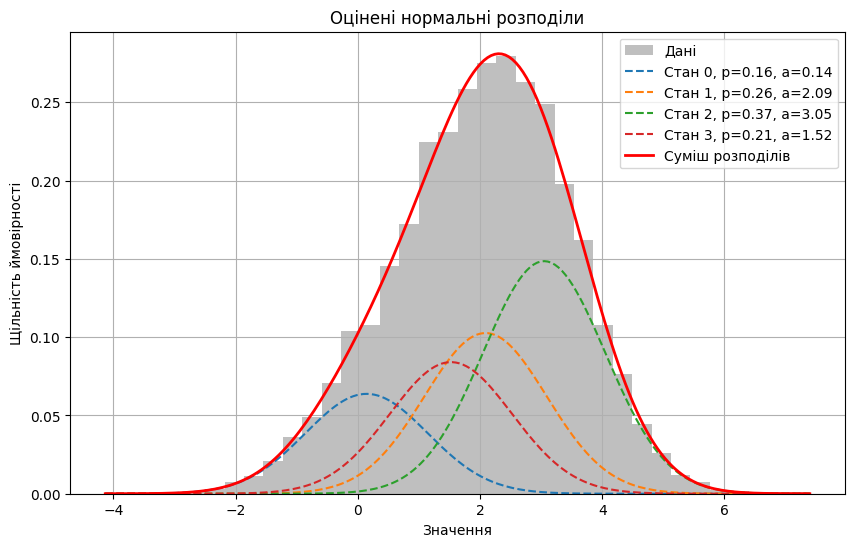

In [ ]:
if __name__ == "__main__":
    n = 10_000
    states = [0, 1, 2, 3]
    # np.random.seed(42)
    data, _ = generate_sequence(n)  # Генерація даних

    p_k, a_k, log_likelihood_history = self_learning_algorithm(data, states)

    print("Остаточні ймовірності станів:", p_k)
    print("Остаточні параметри a_k:", a_k)

    # Візуалізація
    plot_log_likelihood(log_likelihood_history)
    plot_distributions(data, states, p_k, a_k)

Ітерація 1: лог-правдоподібність = -180860.34259777356
Ітерація 2: лог-правдоподібність = -177493.2100730341
Ітерація 3: лог-правдоподібність = -176670.18042439112
Ітерація 4: лог-правдоподібність = -176513.29119301712
Ітерація 5: лог-правдоподібність = -176444.58409674422
Ітерація 6: лог-правдоподібність = -176390.71515056488
Ітерація 7: лог-правдоподібність = -176344.22424333182
Ітерація 8: лог-правдоподібність = -176303.7142339262
Ітерація 9: лог-правдоподібність = -176268.37106780504
Ітерація 10: лог-правдоподібність = -176237.5039534034
Ітерація 11: лог-правдоподібність = -176210.5007820373
Ітерація 12: лог-правдоподібність = -176186.8192046541
Ітерація 13: лог-правдоподібність = -176165.9814288945
Ітерація 14: лог-правдоподібність = -176147.56960935454
Ітерація 15: лог-правдоподібність = -176131.22140111277
Ітерація 16: лог-правдоподібність = -176116.62555583962
Ітерація 17: лог-правдоподібність = -176103.5174779347
Ітерація 18: лог-правдоподібність = -176091.6746702089
Ітерація 

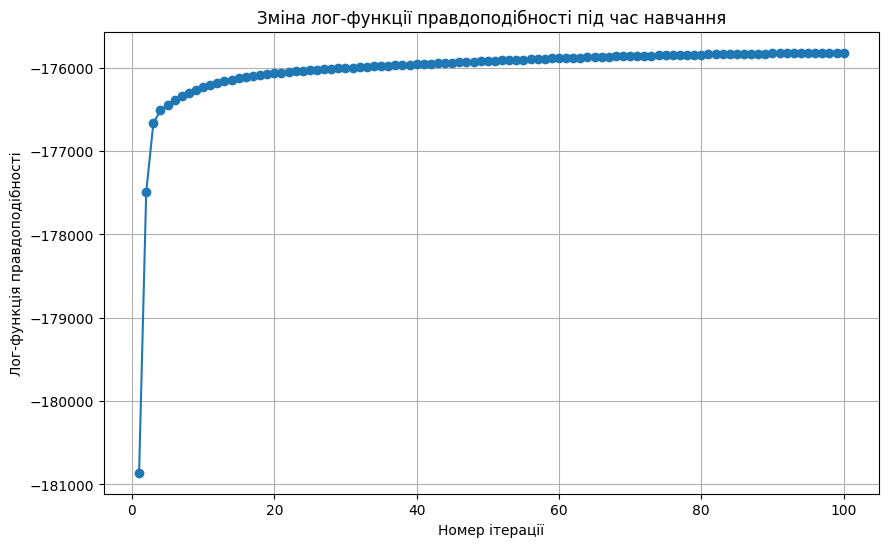

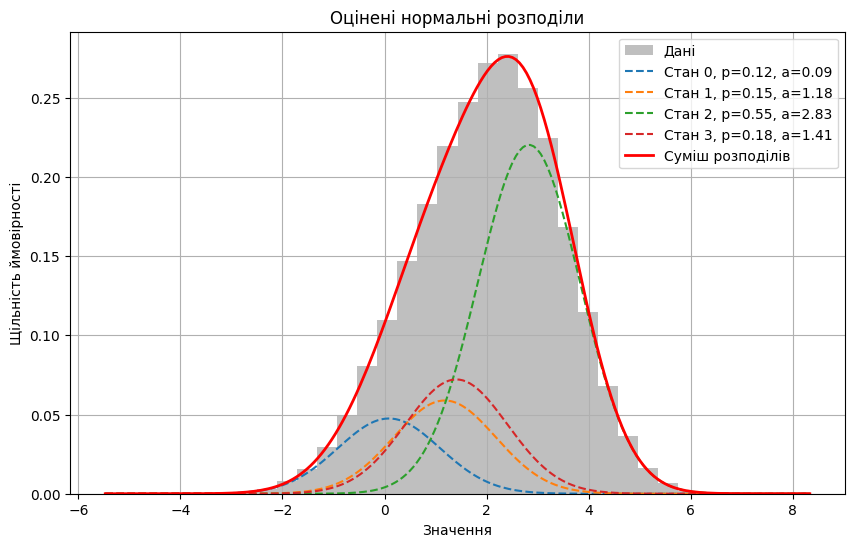

In [ ]:
if __name__ == "__main__":
    n = 100_000
    states = [0, 1, 2, 3]
    # np.random.seed(42)
    data, _ = generate_sequence(n)  # Генерація даних

    p_k, a_k, log_likelihood_history = self_learning_algorithm(data, states)

    print("Остаточні ймовірності станів:", p_k)
    print("Остаточні параметри a_k:", a_k)

    # Візуалізація
    plot_log_likelihood(log_likelihood_history)
    plot_distributions(data, states, p_k, a_k)

Алгоритм самонавчання демонструє хорошу збіжність і стабільність оцінок із ростом розміру вибірки
𝑛. Для малих
𝑛 можливі варіації в оцінках параметрів, однак зі збільшенням
𝑛 ці варіації поступово зникають. Алгоритм підтверджує свою ефективність у задачах оцінки параметрів, де вибірки є незалежними та нормально розподіленими.

На всіх графіках видно, що сумарний розподіл (червона крива) добре апроксимує гістограму даних. Однак із ростом
𝑛 узгодженість між гістограмою та моделлю значно покращується.